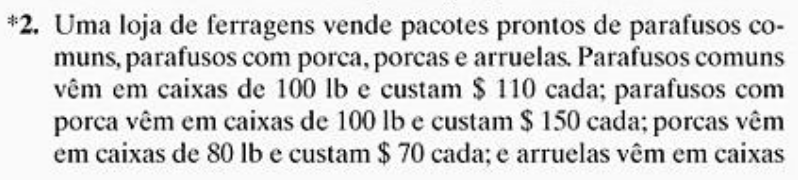
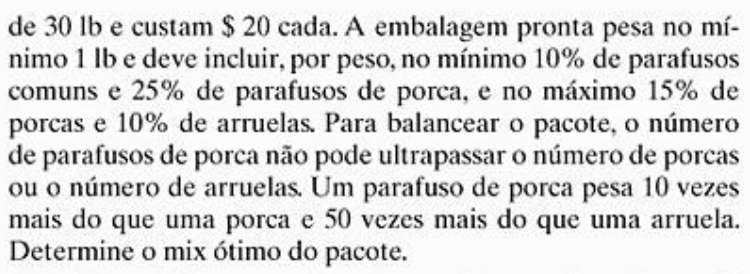

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Mix_Otimo_Pacote_Ferramentas')

In [3]:
# --- Parâmetros extraídos do enunciado ---

# Componentes do pacote
componentes = ['comuns', 'com_porca', 'porcas', 'arruelas']

# Peso total do pacote final
peso_pacote_lb = 1.0

# Cálculo do custo por lb para cada componente
custo_por_lb = {
    'comuns': 110 / 100,  # $1.10/lb
    'com_porca': 150 / 100,  # $1.50/lb
    'porcas': 70 / 80,     # $0.875/lb
    'arruelas': 20 / 30    # ~$0.667/lb
}

# Regras de composição por PESO
composicao_min = {'comuns': 0.10, 'com_porca': 0.25}
composicao_max = {'porcas': 0.15, 'arruelas': 0.10}

# Relações de peso para as restrições de CONTAGEM
# N_pp <= N_p  => (Peso_pp / Peso_unit_pp) <= (Peso_p / Peso_unit_p)
# Como Peso_unit_pp = 10 * Peso_unit_p, a restrição se torna: Peso_pp <= 10 * Peso_p
# N_pp <= N_a  => (Peso_pp / Peso_unit_pp) <= (Peso_a / Peso_unit_a)
# Como Peso_unit_pp = 50 * Peso_unit_a, a restrição se torna: Peso_pp <= 50 * Peso_a

In [4]:
# 1. Variáveis de Decisão
# Peso (em lb) de cada componente no pacote final de 1 lb
peso_lb = model.continuous_var_dict(componentes, name='Peso', lb=0)


# 2. Função Objetivo
# Minimizar o custo total do pacote de 1 lb
expressao_custo = (custo_por_lb[c] * peso_lb[c] for c in componentes)
custo_total_pacote = model.sum(expressao_custo)
model.minimize(custo_total_pacote)


# 3. Restrições

# Restrição 1: Peso Total do Pacote
# A soma dos pesos dos componentes deve ser exatamente 1 lb.
expressao_peso_total = (peso_lb[c] for c in componentes)
soma_peso_total = model.sum(expressao_peso_total)
restr_peso_total_logica = soma_peso_total == peso_pacote_lb
model.add_constraint(restr_peso_total_logica, ctname='peso_total_pacote')

# Restrição 2: Composição Mínima por Peso
restr_min_comuns_logica = peso_lb['comuns'] >= composicao_min['comuns'] * peso_pacote_lb
model.add_constraint(restr_min_comuns_logica, ctname='min_comuns')

restr_min_com_porca_logica = peso_lb['com_porca'] >= composicao_min['com_porca'] * peso_pacote_lb
model.add_constraint(restr_min_com_porca_logica, ctname='min_com_porca')

# Restrição 3: Composição Máxima por Peso
restr_max_porcas_logica = peso_lb['porcas'] <= composicao_max['porcas'] * peso_pacote_lb
model.add_constraint(restr_max_porcas_logica, ctname='max_porcas')

restr_max_arruelas_logica = peso_lb['arruelas'] <= composicao_max['arruelas'] * peso_pacote_lb
model.add_constraint(restr_max_arruelas_logica, ctname='max_arruelas')

# Restrição 4: Balanceamento por Contagem (convertido para peso)
# Número de parafusos com porca <= Número de porcas
restr_balanco_porcas_logica = peso_lb['com_porca'] - 10 * peso_lb['porcas'] <= 0
model.add_constraint(restr_balanco_porcas_logica, ctname='balanco_num_porcas')

# Número de parafusos com porca <= Número de arruelas
restr_balanco_arruelas_logica = peso_lb['com_porca'] - 50 * peso_lb['arruelas'] <= 0
model.add_constraint(restr_balanco_arruelas_logica, ctname='balanco_num_arruelas')

docplex.mp.LinearConstraint[balanco_num_arruelas](Peso_com_porca-50Peso_arruelas,LE,0)

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Mínimo por Pacote de 1lb: ${custo_minimo:,.4f}\n")

    print("--- Composição Ótima do Pacote (por peso em lb) ---")
    for c in componentes:
        peso_val = peso_lb[c].solution_value
        print(f"  - {c.capitalize():<12}: {peso_val:,.4f} lb ({peso_val:.2%})")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
LP Presolve eliminated 7 rows and 4 columns.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.00 ticks)

------ SOLUÇÃO ÓTIMA ------

Custo Mínimo por Pacote de 1lb: $1.1229

--- Composição Ótima do Pacote (por peso em lb) ---
  - Comuns      : 0.5000 lb (50.00%)
  - Com_porca   : 0.2500 lb (25.00%)
  - Porcas      : 0.1500 lb (15.00%)
  - Arruelas    : 0.1000 lb (10.00%)
